In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import stats
from scipy.optimize import curve_fit

In [2]:
# load data
data = pd.read_csv("../Data/IRED_screening_data.csv")

In [3]:
data

,Unnamed: 0,Name,R-RetTime,R-Type,R-Area,R-Height,R-Width,R-Start,R-End,R-HPLC-concentration,...,S-Fluorescence,S-RFU/OD,S-Biosensor-concentration,HPLC batch,R-growth-plate,S-growth-plate,ired,run_order,R-Biosensor-concentration-err,S-Biosensor-concentration-err
0,0,IR1-1,5.032990456,VB,1.234411e+06,52969.13281,0.298444092,4.928639412,6.429362774,0.586745,...,111401,154295.01390,43.090317,1,1,2,IR1,0,1.075658,0.861307
1,1,IR1-2,5.207015514,BB,4.878561e+05,24313.21094,0.266557187,5.045383453,6.127449989,0.000000,...,125541,173399.17130,46.227974,1,1,2,IR1,1,1.114447,0.832161
2,2,IR1-3,5.21252346,VB,3.350695e+06,84253.42188,0.493484497,5.043547153,6.548189163,2.262890,...,130064,176477.61190,46.737210,1,1,2,IR1,2,1.093692,0.839465
3,3,IR2-1,5.251245499,VB,1.341507e+07,868455.3125,0.215625584,5.000967503,6.767403126,10.156388,...,188836,212653.15320,52.400508,1,1,2,IR2,3,1.083225,0.801876
4,4,IR2-2,5.26531601,BB,9.370031e+06,733588.0625,0.184431911,5.015933514,6.068516731,6.987014,...,186438,214296.55170,52.665070,1,1,2,IR2,4,1.066123,0.800347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,139,S2C4-2,5.034426689,BB,3.273459e+07,3293122.25,0.148435056,4.445300102,7.856472015,26.057488,...,26161,31070.07126,15.044475,2,3,3,S2C4,139,2.722112,2.589415
140,140,S2C4-3,5.033613205,BB,3.222236e+07,3288104.75,0.146794528,4.445283413,7.842768192,25.605934,...,26052,30613.39600,14.932513,2,3,3,S2C4,140,2.700046,2.243356
141,141,TAA-1,None,None,0.000000e+00,None,None,None,None,0.000000,...,16804,22081.47175,7.597308,2,3,3,TAA,141,0.543239,4.872955
142,142,TAA-2,None,None,0.000000e+00,None,None,None,None,0.000000,...,16538,21229.78177,6.829658,2,3,3,TAA,142,0.508588,4.775422


In [4]:
def log_line_fnct(x, A, B):
    return np.log(A + B*x)

In [5]:
# define plotting function
sns.set()
sns.set_style("white")
plt.rcParams['font.sans-serif'] = ['Arial'] 
sns.set_style("ticks", {'xtick.direction':'in', 'xtick.top':False, 'ytick.direction':'in', 'ytick.right':False, })
plt.rcParams["xtick.labelsize"] = 22
plt.rcParams["ytick.labelsize"] = 22

offset_dict = {}

def plot_correlation(x, y, color, x_label, y_label, saveto=None, background=None, symlog=False,
                     calculate_correlations=True, include_fit=True):
    x = np.array(x)
    y = np.array(y)
    
    if calculate_correlations:
        x_corr = x[(~np.isnan(x))&(~np.isnan(y))&(~np.isinf(x))&(~np.isinf(y))]
        y_corr = y[(~np.isnan(x))&(~np.isnan(y))&(~np.isinf(x))&(~np.isinf(y))]
        
        spear = stats.spearmanr(x_corr, y_corr)
        print(f'Spearman R: {spear.statistic:.2f}, p-value: {spear.pvalue:.2e}')
        
        pears = stats.pearsonr(np.log(x_corr[(x_corr>0)&(y_corr>0)]), np.log(y_corr[(x_corr>0)&(y_corr>0)]))
        print(f'Pearson R: {pears.statistic:.2f}, p-value: {pears.pvalue:.2e} (log values)')
        
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot()
    plt.ticklabel_format(style="plain", axis="x")
    
    plt.xlabel(x_label, fontsize=24, labelpad=15)
    plt.ylabel(y_label, fontsize=24, labelpad=15)
    if symlog:
        ax.set_xscale("symlog")
    else:
        ax.set_xscale("log")
    ax.set_yscale("log")
    if background is not None:
        plt.axhline(y=background, color='grey', linestyle='--', linewidth=2)
    plt.scatter(x, y, s=70, facecolor=color, edgecolors="#000000")
    
    if include_fit:
        x_fit = x[(~np.isnan(x))&(~np.isnan(y))&(~np.isinf(x))&(~np.isinf(y))&(y>0)]
        y_fit = y[(~np.isnan(x))&(~np.isnan(y))&(~np.isinf(x))&(~np.isinf(y))&(y>0)]
        
        popt, pcov = curve_fit(log_line_fnct, x_fit, np.log(y_fit))
        x_max = max(x_fit)
        x_min = min(x_fit[x_fit>0])
        x_plot = np.array([0] + list(np.logspace(np.log10(x_min), np.log10(x_max), 40)))
        y_plot = np.exp(log_line_fnct(x_plot, *popt))
        ax.plot(x_plot, y_plot, '--k')
        
        print(f'Offset: {popt[0]:.3e}')
        
        if 'R-TIQ' in x_label:
            offset_dict['R'] = popt[0]
        
        elif 'S-TIQ' in x_label:
            offset_dict['S'] = popt[0]
    
    if saveto is not None:
        plt.savefig(saveto, format="svg")
    plt.show()

Spearman R: 0.66, p-value: 4.16e-19
Pearson R: 0.65, p-value: 2.66e-14 (log values)
Offset: 8.383e-01


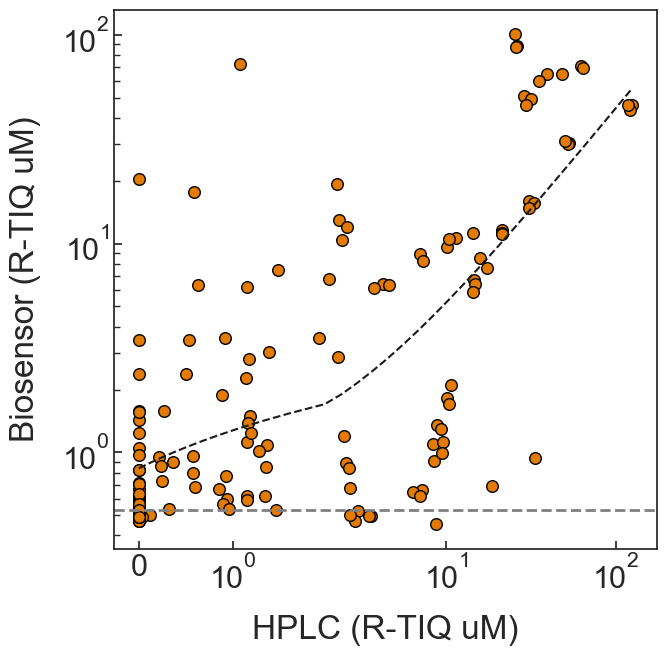

In [6]:
# Plot R correlation

x = data["R-HPLC-concentration"]

y = data["R-Biosensor-concentration"]

# calculate the biosensor background
average_biosensor_bkgrd = data[data["Name"].isin(["TAA-1", "TAA-2", "TAA-3"])]["R-Biosensor-concentration"].mean()

# set axis labels
x_label = "HPLC (R-TIQ uM)"
y_label = "Biosensor (R-TIQ uM)"

#orange
color = "#e37a02"

#name the SVG file output
save_to = None #"R_hplc_biosensor_correlation.svg"

plot_correlation(x,y, color, x_label, y_label, save_to, average_biosensor_bkgrd, symlog=True)

Spearman R: 0.75, p-value: 1.90e-27
Pearson R: 0.88, p-value: 3.41e-35 (log values)
Offset: 2.727e+00


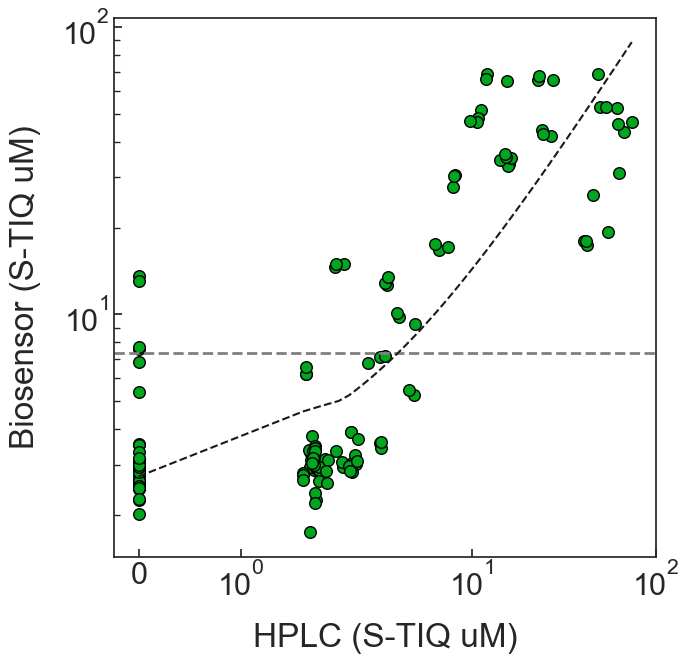

In [7]:
# Plot S correlation

x = data["S-HPLC-concentration"]

y = data["S-Biosensor-concentration"]

# calculate the biosensor background
average_biosensor_bkgrd = data[data["Name"].isin(["TAA-1", "TAA-2", "TAA-3"])]["S-Biosensor-concentration"].mean()

# set axis labels
x_label = "HPLC (S-TIQ uM)"
y_label = "Biosensor (S-TIQ uM)"

#green
color = "#00a61e"

#name the SVG file output
save_to = None #"S_hplc_biosensor_correlation.svg"

plot_correlation(x,y, color, x_label, y_label, save_to, average_biosensor_bkgrd, symlog=True)

Spearman R: 0.80, p-value: 1.12e-24
Pearson R: 0.75, p-value: 3.93e-18 (log values)
Offset: 3.037e-01


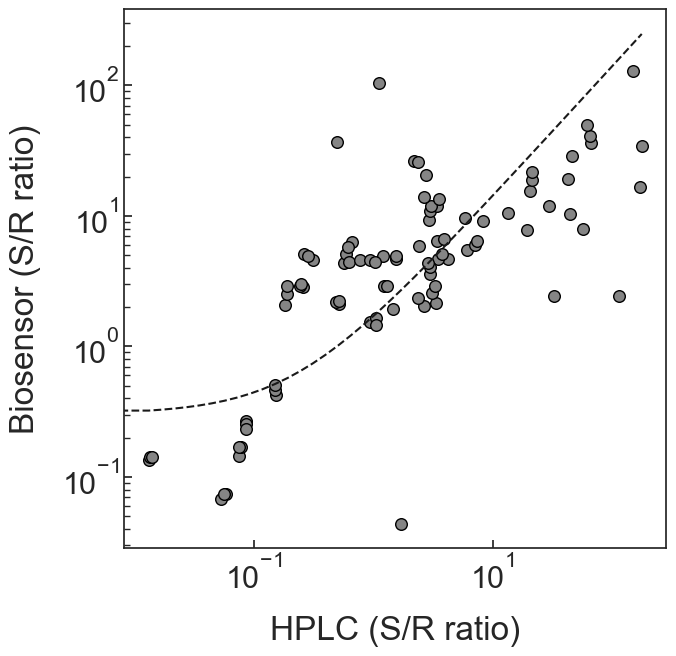

In [8]:
# Plot S/R ratio correlation

x = data["S-HPLC-concentration"] / data["R-HPLC-concentration"]

y = data["S-Biosensor-concentration"] / data["R-Biosensor-concentration"]

# set axis labels
x_label = "HPLC (S/R ratio)"
y_label = "Biosensor (S/R ratio)"

#grey
color = "#858585"

#name the SVG file output
save_to = None #"SR_ratio_correlation.svg"

plot_correlation(x,y, color, x_label, y_label, save_to)

Spearman R: -0.15, p-value: 1.21e-01
Pearson R: 0.79, p-value: 7.27e-11 (log values)
Offset: 3.742e-02


C:\Users\djross\AppData\Local\Temp\2\ipykernel_10596\1477818947.py:2: RuntimeWarning: invalid value encountered in log
  return np.log(A + B*x)


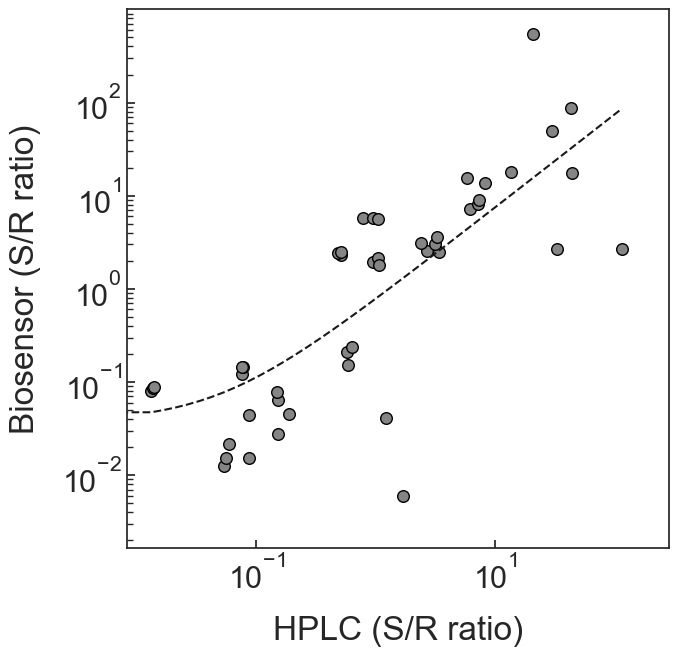

In [9]:
# Plot S/R ratio correlation, with offset subtracted.

x = data["S-HPLC-concentration"] / data["R-HPLC-concentration"]

y = (data["S-Biosensor-concentration"] - offset_dict['S']) / (data["R-Biosensor-concentration"] - offset_dict['S'])

# set axis labels
x_label = "HPLC (S/R ratio)"
y_label = "Biosensor (S/R ratio)"

#grey
color = "#858585"

#name the SVG file output
save_to = None #"SR_ratio_correlation.svg"

plot_correlation(x,y, color, x_label, y_label, save_to, symlog=False, include_fit=True)